In [159]:
%pylab qt5
import os

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (11, 7)

import scipy.optimize

Populating the interactive namespace from numpy and matplotlib


In [160]:
tt = []
xx1 = []; xx2 = []
TT = [];
for i in range(1, 4+1):
    txt = loadtxt(f'punkte_loch{i}_schwebung.txt', skiprows=5, delimiter='\t')
    t_, x1_, x2_ = transpose(txt)
    T_ = t_[-1]
    tt.append(t_)
    xx1.append(x1_); xx2.append(x2_)
    TT.append(T_)

vals = list(zip(tt, xx1, xx2, TT))

In [161]:
t, x1, x2, TT = vals[4 - 1]

In [162]:
print(2*pi/t[-1])

0.0913253678369126


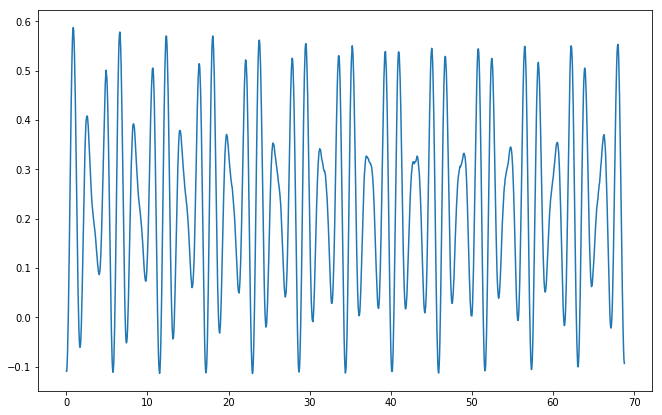

In [163]:
plt.plot(t, x1)

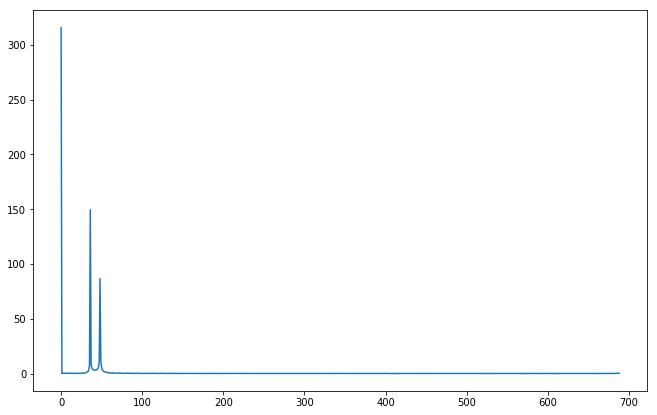

In [164]:
freq = fft.rfft(x1)
plt.plot(abs(freq))

In [165]:
n1, n2 = argpartition(-abs(freq), 2)[1:3]
print(n1, n2)

36 48


In [166]:
w1 = 2*pi/t[-1] * n1; w2 = 2*pi/t[-1] * n2
A1 = .9* sqrt(2*pi) * abs(freq[n1])/len(x1); phi1 = angle(freq[n1])
A2 = .9* sqrt(2*pi) * abs(freq[n2])/len(x1); phi2 = angle(freq[n2])

In [167]:
w1, A1, phi1
w2, A2, phi2
A = .5*(A1 + A2)

(3.2877132421288535, 0.24486099321128385, -3.077381606961986)

(4.383617656171805, 0.14193514655301742, 3.0975964105671934)

/usr/local/lib/python3.6/dist-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


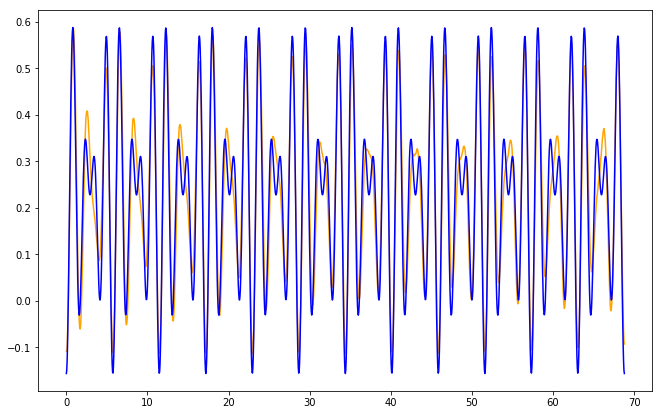

In [168]:
# _p1[0].remove(); _p2[0].remove()
_p1 = plt.plot(t, x1, 'orange')
_p2 = plt.plot(t, A * cos(w1*t + phi1) + A * cos(w2*t + phi2) + freq[0]/len(x1), 'blue')

In [169]:
2*pi/t[-1]

0.0913253678369126

In [177]:
def link(t, w1, w2, A1, A2, phi1, phi2):
    return A1*cos(w1*t + phi1) + A2*cos(w2*t + phi2)

def glink(t, w1, w2, A, phi1, phi2):
    return A* (cos(w1*t + phi1) + cos(w2*t + phi2))

def linkd(t, w1, w2, A1, A2, phi1, phi2, g):
    return (A1*cos(w1*t + phi1) + A2*cos(w2*t + phi2)) * exp(-g*t)

def schweb(t, wi, wa, B, phii, phia):
    return B * cos(wa*t + phia) * cos(wi*t + phii)

In [203]:
a1 = x1 - mean(x1)

### fitten Schwebung direkt

In [204]:
wa = (w1 - w2)/2; wi = (w1 + w2)/2
p0 = [(w1 - w2)/2, (w1 + w2)/2, 2*A, (phi1 - phi2)/2, (phi1 + phi2)/2]
popt, pcov = scipy.optimize.curve_fit(schweb, t, a1, p0=p0,
                                      maxfev=1000)

wi_, wa_, B_, phii_, phia_ = popt
err_wi, err_wa, err_B, err_phii, err_phia = diag(pcov)
for v, err in zip(popt, diag(pcov)):
    print(f'{v} +- {err}')
popt - p0

-0.5556373778942705 +- 1.2635333069767912e-07
3.836860127842675 +- 1.1616838449135382e-07
0.34459206210430515 +- 5.5867144178455594e-06
-2.8119050019703438 +- 0.00019864801939342147
-0.12497565868217937 +- 0.00018409857393033576


array([-0.00768517,  0.00119468, -0.04220408,  0.27558401, -0.13508306])

chi^2: 1.6355605388154135


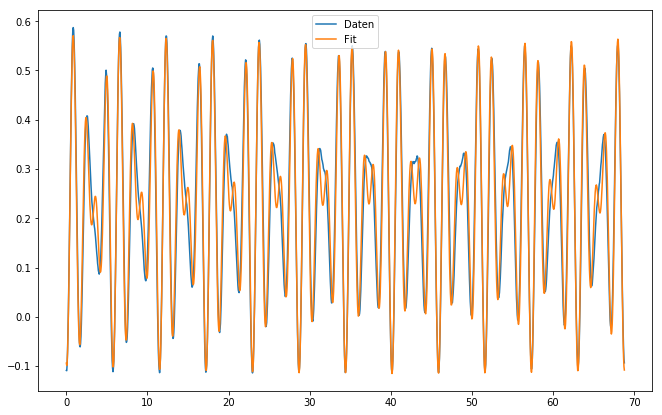

In [205]:
_ = plt.plot(t, x1)
fit = vectorize(schweb)(t, wi_, wa_, B_, phii_, phia_) + mean(x1)
_ = plt.plot(t, fit)
_ = plt.legend(['Daten', 'Fit'])
print('chi^2:', norm(x1 - fit))

### fitten Summe der Eigenmoden

In [206]:
popt, pcov = scipy.optimize.curve_fit(glink, t, a1, p0=[w1, w2, A, phi1, phi2],
                                      maxfev=1000)
w1_, w2_, A_, phi1_, phi2_ = popt
err_w1, err_w2, err_A, err_phi1, err_phi2 = diag(pcov)
for v, err in zip(popt, diag(pcov)):
    print(f'{v} +- {err}')
popt - [w1, w2, A, phi1, phi2]

3.281222720918917 +- 2.4111833274237934e-07
4.392497545453028 +- 2.4392169849848735e-07
0.17229602670313915 +- 1.3966784628297606e-06
-2.936879576105281 +- 0.0003807768647408442
2.6869280637835424 +- 0.00038471431296373357


array([-0.00649052,  0.00887989, -0.02110204,  0.14050203, -0.41066835])

In [ ]:
_ = plt.plot(t, x1)
fit = vectorize(glink)(t, w1_, w2_, A_, phi1_, phi2_) + mean(x1)
_ = plt.plot(t, vectorize(glink)(t, w1_, w2_, A_, phi1_, phi2_) + mean(x1))
_ = plt.legend(['Daten', 'Fit'])
print('chi^2:', norm(x1 - fit))

### fitten linearkombination der Eigenmoden

In [188]:
popt, pcov = scipy.optimize.curve_fit(link, t, x1, p0=[w1, w2, A1, A2, phi1, phi2],
                                      maxfev=1000)
w1_, w2_, A1_, A2_, phi1_, phi2_ = popt
err_w1, err_w2, err_A1, err_A2, err_phi1, err_phi2 = diag(pcov)
for v, err in zip(popt, diag(pcov)):
    print(f'{v} +- {err}')
popt - [w1, w2, A1, A2, phi1, phi2]

3.2792836115385833 +- 4.091541138810292e-06
4.389964160586156 +- 1.2177691230791229e-05
0.2176364044181127 +- 7.705341684737318e-05
0.12691849691203685 +- 7.668923917499548e-05
-2.8712915991244996 +- 0.006461889000251044
2.771237580172635 +- 0.019210020255118226


array([-0.00842963,  0.0063465 , -0.02722459, -0.01501665,  0.20609001,
       -0.32635883])

chi^2: 0.3446609235427132


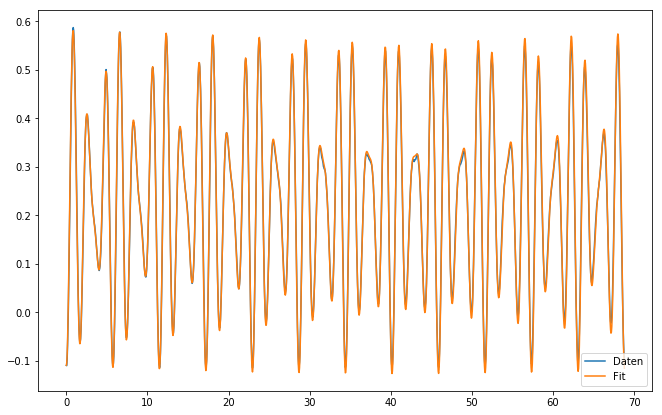

In [196]:
_ = plt.plot(t, x1)
fit = vectorize(link)(t, w1_, w2_, A1_, A2_, phi1_, phi2_) + mean(x1)
_ = plt.plot(t, fit)
_ = plt.legend(['Daten', 'Fit'])
print('chi^2:', norm(x1 - fit))

### because we can: Linearkombination mit Dämpfung

In [190]:
popt, pcov = scipy.optimize.curve_fit(linkd, t, x1, p0=[w1, w2, A1, A2, phi1, phi2, 0],
                                      maxfev=1000)
w1_, w2_, A1_, A2_, phi1_, phi2_, g_ = popt
err_w1, err_w2, err_A1, err_A2, err_phi1, err_phi2, err_g = diag(pcov)
for v, err in zip(popt, diag(pcov)):
    print(f'{v} +- {err}')
popt - [w1, w2, A1, A2, phi1, phi2, 1]

3.2792787711317093 +- 4.096090312060344e-06
4.389978387917109 +- 1.2198083585086835e-05
0.22442232190516076 +- 0.0002503574305405922
0.13084338621341862 +- 0.00013816782240009493
-2.8713395337735266 +- 0.006269630422551876
2.772198073647463 +- 0.018656890578324124
0.0008987143030879338 +- 2.9614946646636195e-06


array([-0.00843447,  0.00636073, -0.02043867, -0.01109176,  0.20604207,
       -0.32539834, -0.99910129])

chi^2: 0.23650861066697787


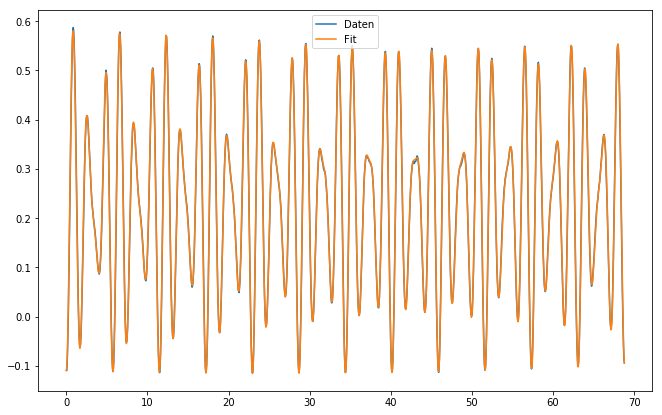

In [195]:
_ = plt.plot(t, x1)
fit = vectorize(linkd)(t, w1_, w2_, A1_, A2_, phi1_, phi2_, g_) + mean(x1)
_ = plt.plot(t, fit)
_ = plt.legend(['Daten', 'Fit'])
print('chi^2:', norm(x1 - fit))